# Definizioni iniziali

### Pacchetti

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Matplotlib

In [2]:
def show_image(image, title=None):
    img = image
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    figure, axes = plt.subplots(figsize=(20, 20))
    axes.imshow(img, cmap='gray')
    axes.set_title(title)
    axes.axis('off')
    plt.show()

def show_horizontal_images(images):
    figure, subplots = plt.subplots(1, len(images), figsize=(20, 20))
    figure.subplots_adjust(wspace=0.01)
    for i, img in enumerate(images):
        subplots[i].imshow(img[0], cmap='gray')
        subplots[i].set_title(img[1])
        subplots[i].axis('off')
    plt.show()

### Allineamento

#### Funzioni di misura

In [3]:
def mutual_information(img1: np.ndarray, img2: np.ndarray, bins: int = 256) -> float:
    """
    Compute the mutual information (MI) between two grayscale images.
    
    :param img1: First image in grayscale.
    :param img2: Second image in grayscale.
    :param bins: Number of histogram bins to use (256 for 8-bit images).
    :return: Mutual information (in bits) between img1 and img2.
    """
    # Convert images to 1D numpy arrays (flatten) if they are not already
    img1 = img1.ravel()
    img2 = img2.ravel()

    # Compute the joint histogram
    # histogram2d returns the 2D histogram and bin edges
    joint_hist, x_edges, y_edges = np.histogram2d(img1, img2, bins=bins)
    
    # Normalize the joint histogram to get the joint PDF p(x,y)
    joint_pdf = joint_hist / np.sum(joint_hist)
    
    # Compute the marginal PDFs p(x) and p(y)
    p_x = np.sum(joint_pdf, axis=1)  # Sum over columns -> marginal over x
    p_y = np.sum(joint_pdf, axis=0)  # Sum over rows -> marginal over y

    # Only consider non-zero values to avoid log(0)
    # MI = sum p(x,y)*log( p(x,y)/(p(x)*p(y)) )
    non_zero_idxs = joint_pdf > 0
    mi = np.sum(joint_pdf[non_zero_idxs] * 
                np.log2(joint_pdf[non_zero_idxs] / 
                        (p_x[np.newaxis].T @ p_y[np.newaxis])[non_zero_idxs]))
    
    return mi

def calculate_mse(img1, img2) -> float:
    """
    Compute the mean squared error (MSE) between two images.
    
    :param img1: First image.
    :param img2: Second image.
    :return: Mean squared error between img1 and img2.
    """
    # Compute the squared error between the two images
    se = (img1 - img2) ** 2
    
    # Compute the mean squared error
    mse = np.mean(se)
    
    return mse

#### Filtri

In [4]:
FILTER_DISTANCE = 20
LOWES_RATIO = 0.75

def filter_LR(matches, threshold=LOWES_RATIO):
    filtered_matches = []
    for m in matches:
        if m[0].distance < threshold * m[1].distance:
            filtered_matches.append(m[0])
    return filtered_matches

def filter_ED(matches, keypoints, distance=FILTER_DISTANCE):
    filtered_matches = []
    for m in matches:
        euclidean_distance = np.linalg.norm(np.array(keypoints[0][m.queryIdx].pt) - np.array(keypoints[1][m.trainIdx].pt))
        if euclidean_distance < distance:
            filtered_matches.append(m)
    return filtered_matches

#### Funzione di allineamento

In [5]:
MODE_SIFT = 0
MODE_ORB = 1

NFEATURES = 10000

def align(image_1, image_2, image_to_align=None, mode=MODE_SIFT, lr=False, ed=False, nfeatures=NFEATURES):
    """
    Align two images using SIFT or ORB features.
    Can use Lowe's ratio test and Euclidean distance filtering.
    """
    # If no image to align is provided, use image_2
    if image_to_align is None:
        image_to_align = image_2
    
    # Detect keypoints and compute descriptors using SIFT or ORB
    if mode == MODE_SIFT:
        sift = cv2.SIFT_create(nfeatures=nfeatures)
        keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
        keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)
    elif mode == MODE_ORB:
        orb = cv2.ORB_create(nfeatures=nfeatures)
        keypoints_1, descriptors_1 = orb.detectAndCompute(image_1, None)
        keypoints_2, descriptors_2 = orb.detectAndCompute(image_2, None)
    else:
        raise Exception("Mode not supported")
    
    # Match descriptors using bruteforce
    if lr: # If using Lowe's ratio
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)
        matches = filter_LR(matches)
    else: # If not using Lowe's ratio
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
        matches = bf.match(descriptors_1, descriptors_2)

    if ed: # If using Euclidean distance
        filtered_matches = filter_ED(matches, (keypoints_1, keypoints_2))
    else:
        filtered_matches = matches
    
    # Extract points from matches for RANSAC
    points = ([], [])
    for match in filtered_matches:
        points[0].append(keypoints_1[match.queryIdx].pt)
        points[1].append(keypoints_2[match.trainIdx].pt)
    
    points_1 = np.array(points[0])
    points_2 = np.array(points[1])
    warp_matrix, mask = cv2.estimateAffine2D(points_2, points_1)

    # Apply the warp matrix to the image to align
    height, width = image_to_align.shape[:2]
    aligned_image = cv2.warpAffine(image_to_align, warp_matrix, (width, height))

    return aligned_image

# Confronti CLAHE

#### Controllo dei diversi parametri per applicare CLAHE

In [ ]:
clipLimits = [1.0, 2.0, 4.0, 8.0, 12.0, 16.0, 17.0, 18.0, 19.0, 20.0]
tileGridSizes = [(4, 4), (7, 7), (8, 8), (9, 9), (12, 12)]

label_free = cv2.cvtColor(cv2.imread("../../Materiale/Prove/non_colorato.png"), cv2.COLOR_BGR2GRAY)
stained = cv2.cvtColor(cv2.imread("../../Materiale/Prove/colorato.png"), cv2.COLOR_BGR2GRAY)

highest = (None, None, 0)
for clipLimit in clipLimits:
    for tileGridSize in tileGridSizes:
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        label_free_clahe = clahe.apply(label_free)
        stained_clahe = clahe.apply(stained)

        aligned_image = align(label_free_clahe, stained_clahe, image_to_align=stained, mode=MODE_ORB, lr=False, ed=True)
        mi = mutual_information(label_free, aligned_image)

        # print(f"CLAHE\tCL: {clipLimit}\t\tTGS: {tileGridSize}\tSCORE: {mi}")
        if mi > highest[2]:
            highest = (clipLimit, tileGridSize, mi)
            
print(f"BEST - CL: {highest[0]} - TGS: {highest[1]} - SCORE: {highest[2]}")

Ne risulta che il metodo CLAHE migliora si ottiene con `clipLimit=18.0` e `tileGridSize=(8, 8)`.

#### Visualizzazione delle immagini con CLAHE 18.0 (8, 8)

In [ ]:
label_free = cv2.cvtColor(cv2.imread("../../Materiale/Prove/non_colorato.png"), cv2.COLOR_BGR2GRAY)
stained = cv2.cvtColor(cv2.imread("../../Materiale/Prove/colorato.png"), cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=18.0, tileGridSize=(8, 8))
label_free_clahe = clahe.apply(label_free)
stained_clahe = clahe.apply(stained)

aligned_image = align(label_free_clahe, stained_clahe, mode=MODE_ORB, lr=False, ed=True)

difference_original = cv2.absdiff(label_free_clahe, stained_clahe)
difference_aligned_clahe = cv2.absdiff(label_free_clahe, aligned_image)

show_horizontal_images([(label_free_clahe, "Non colorata CLAHE"), (stained_clahe, "Colorata CLAHE"), (aligned_image, "Allineata CLAHE")])
show_horizontal_images([(difference_original, "Differenza originale"), (difference_aligned_clahe, "Differenza allineata")])

# Confronti tra SIFT e ORB con filtri LR e DR

### Controllo con i diversi metodi e le combinazioni di filtri

Si usano le immagini CLAHE con i parametri prestabiliti precedentemente: `18.0 (8, 8)`.

In [ ]:
label_free = cv2.cvtColor(cv2.imread("../../Materiale/Prove/non_colorato.png"), cv2.COLOR_BGR2GRAY)
stained = cv2.cvtColor(cv2.imread("../../Materiale/Prove/colorato.png"), cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=18.0, tileGridSize=(8, 8))
label_free_clahe = clahe.apply(label_free)
stained_clahe = clahe.apply(stained)

highest = (None, None, None, 0)
for mode in [MODE_SIFT, MODE_ORB]:
    for lr in [False, True]:
        for ed in [False, True]:
            aligned_image = align(label_free_clahe, stained_clahe, image_to_align=stained, mode=mode, lr=lr, ed=ed)
            mi = mutual_information(label_free, aligned_image)

            #print(f"ALIGN\tMODE: {mode}\tLR: {lr}\tED: {ed}\tSCORE: {score}")
            if mi > highest[3]:
                highest = (mode, lr, ed, mi)

print(f"BEST - MODE: {'SIFT' if highest[0] == 0 else 'ORB'} - LR: {highest[1]} - ED: {highest[2]} - SCORE: {highest[3]}")

Ne risulta che il metodo migliore con CLAHE 18.0 (8, 8) è SIFT senza Lowe's Ratio e con Distanza Euclidea.

#### Visualizzazione dell'allineamento

ORIGINAL - MI: 0.19364342461548514 - MSE: 104.33944108370724
ALIGNED  - MI: 0.6485383539708702 - MSE: 102.1227777099965
Initial matches: 127 - Final matches: 110


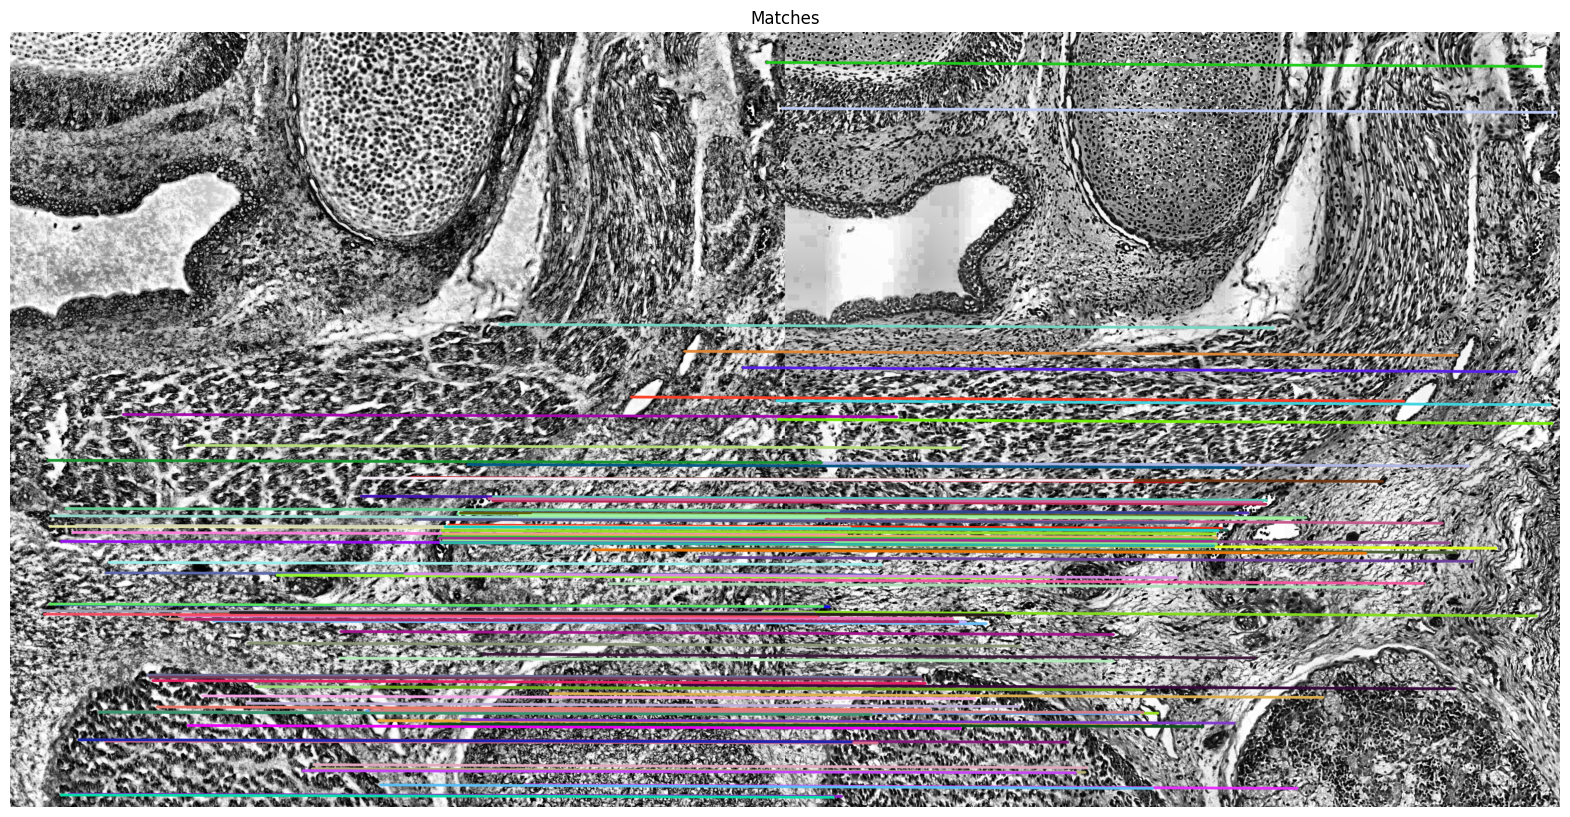

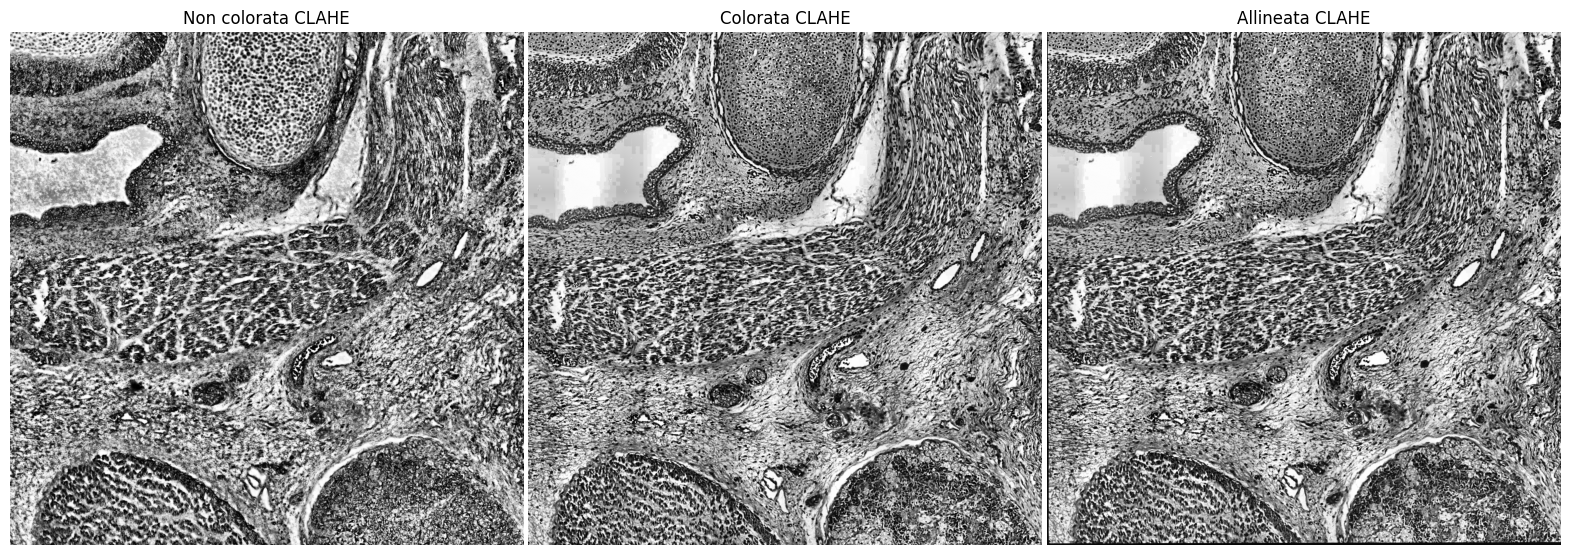

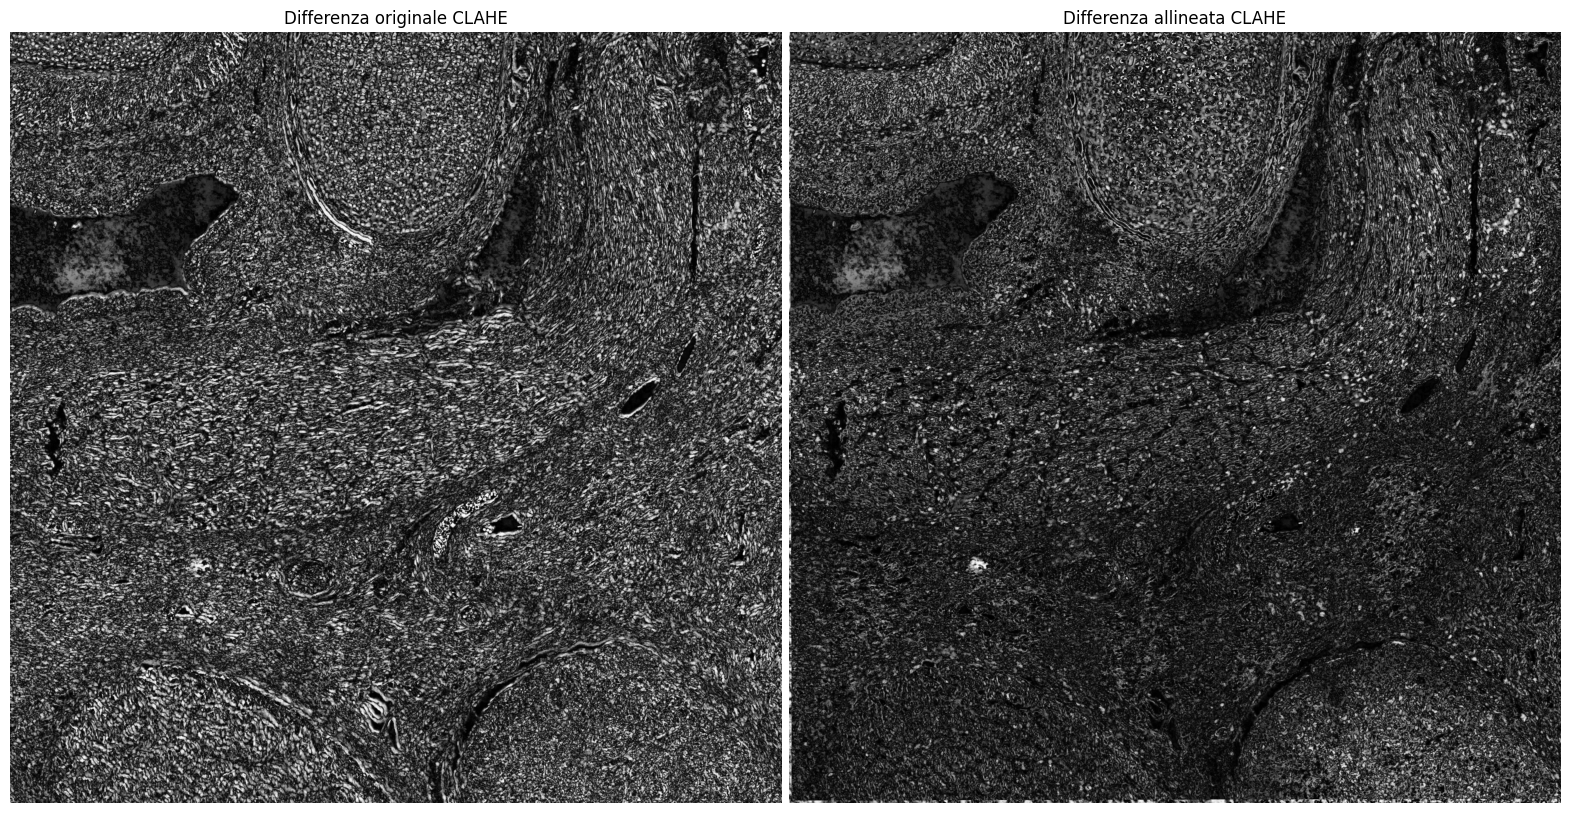

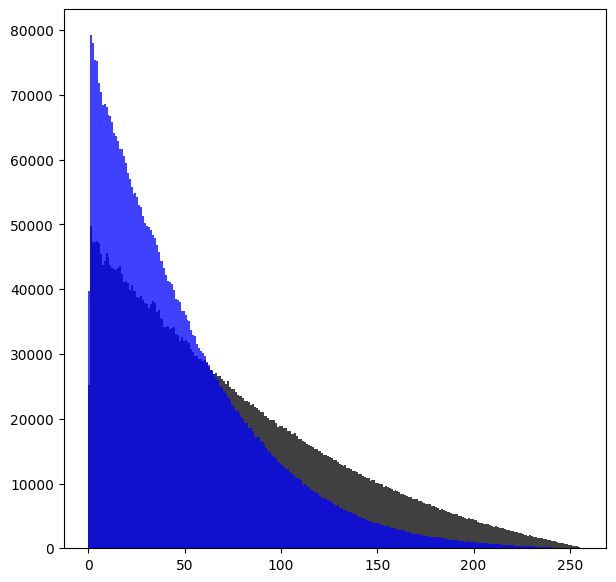

In [12]:
label_free = cv2.cvtColor(cv2.imread("../../Materiale/Prove/non_colorato.png"), cv2.COLOR_BGR2GRAY)
stained = cv2.cvtColor(cv2.imread("../../Materiale/Prove/colorato.png"), cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=18.0, tileGridSize=(8, 8))
label_free_clahe = clahe.apply(label_free)
stained_clahe = clahe.apply(stained)

# Detect keypoints and compute descriptors using SIFT
sift = cv2.SIFT_create(nfeatures=10000)
keypoints_1, descriptors_1 = sift.detectAndCompute(label_free_clahe, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(stained_clahe, None)

# Match descriptors using bruteforce not using Lowe's Ratio
if False:
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
else:
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)
    matches = filter_LR(matches)

# Filter using Euclidean Distance
filtered_matches = filter_ED(matches, (keypoints_1, keypoints_2), distance=200)

# Extract points from matches for RANSAC
points = ([], [])
for match in filtered_matches:
    points[0].append(keypoints_1[match.queryIdx].pt)
    points[1].append(keypoints_2[match.trainIdx].pt)

points_1 = np.array(points[0])
points_2 = np.array(points[1])
warp_matrix, mask = cv2.estimateAffine2D(points_2, points_1)

# Apply the warp matrix to the image to align
height, width = stained.shape[:2]
aligned_image = cv2.warpAffine(stained, warp_matrix, (width, height))
aligned_clahe = clahe.apply(aligned_image)
mi = mutual_information(label_free, aligned_image)
mse = calculate_mse(label_free_clahe, aligned_clahe)

difference_original = cv2.absdiff(label_free_clahe, stained_clahe)
difference_aligned = cv2.absdiff(label_free, aligned_image)
difference_aligned_clahe = cv2.absdiff(label_free_clahe, aligned_clahe)

draw_matches = cv2.drawMatches(
    label_free_clahe, keypoints_1,
    stained_clahe, keypoints_2,
    filtered_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=5)

original_mi = mutual_information(label_free, stained)
original_mse = calculate_mse(label_free_clahe, stained_clahe)
print(f"ORIGINAL - MI: {original_mi} - MSE: {original_mse}")
print(f"ALIGNED  - MI: {mi} - MSE: {mse}")

print(f"Initial matches: {len(matches)} - Final matches: {len(filtered_matches)}")
show_image(draw_matches, "Matches")

show_horizontal_images([(label_free_clahe, "Non colorata CLAHE"), (stained_clahe, "Colorata CLAHE"), (aligned_clahe, "Allineata CLAHE")])
show_horizontal_images([(difference_original, "Differenza originale CLAHE"), (difference_aligned_clahe, "Differenza allineata CLAHE")])

plt.figure(figsize=(7, 7))
plt.hist(difference_original.ravel(), bins=256, range=(0, 256), color='black', alpha=0.75)
plt.hist(difference_aligned_clahe.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.75)
plt.show()